In [174]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mathurinache/3t-fmri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/3t-fmri-dataset


In [3]:
# Let's load some other packages we need
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import time
%matplotlib inline
import nibabel as nib # common way of importing nibabel

Nifti 

Nifti, that most neuroimaging packages should support. As such, usually the first step in any (f)MRI preprocessing pipeline is to convert the scanner-specific files (e.g., PAR/RECs) to nifti

In [4]:
mri_file = '/kaggle/input/3t-fmri-dataset/ds003477/sub-03/ses-1/fmap/sub-03_ses-1_dir-face_run-1_epi.nii'#'anat.nii.gz'
img = nib.load(mri_file)

In [5]:
print(type(img))

<class 'nibabel.nifti1.Nifti1Image'>


In [6]:
print(img.shape)

(80, 80, 44, 3)


### The three parts of nifti images
Nifti images can be roughly divided into three “parts”:

1. The header with metadata;

2. The image data;

3. The affine matrix

All three parts are of course represented in nibabel’s Nifti1Image class. Let’s go through them one by one.



# The header 
The header with metadata provides essential information about the nifti file, such as dimensions, voxel size, data type, and acquisition parameters.

In [7]:
hdr = img.header
hdr.get_zooms()  # it's a 2.7z x 2.7 x 2.97 x 0.7 mm MRI file!

(2.7, 2.7, 2.97, 0.7)

In [8]:
hdr.get_xyzt_units()

('mm', 'sec')

# Getting the data 
this is a typical fMRI data 4D arrays. This 4D array as a series of 3D arrays (volumes), in which the fourth dimension represents time (as shown in the image below).

In [9]:
img_data = img.get_fdata()
print(type(img_data))  # it's a numpy array!
print(img_data.shape)

<class 'numpy.memmap'>
(80, 80, 44, 3)


In [10]:
# printing a small 3x3x3 volume of voxels from the first timepoint
print(img_data[38:41, 38:41, 20:23, 0])

[[[22191.54296875 46924.1015625  63927.73828125]
  [25304.2890625  38326.99609375 59840.9375    ]
  [26892.42382812 32567.359375   56897.59375   ]]

 [[20899.859375   47792.28515625 60814.9921875 ]
  [18485.89453125 43769.0078125  58528.078125  ]
  [20412.83203125 49105.140625   57363.4453125 ]]

 [[35913.03125    41736.1953125  58019.875     ]
  [39152.828125   44425.4375     59480.95703125]
  [42011.47265625 49168.66796875 62805.453125  ]]]


For example, we can visualize a single slice (e.g., 
) of the first volume (
) as follows:

Shape of slice: (80, 44)


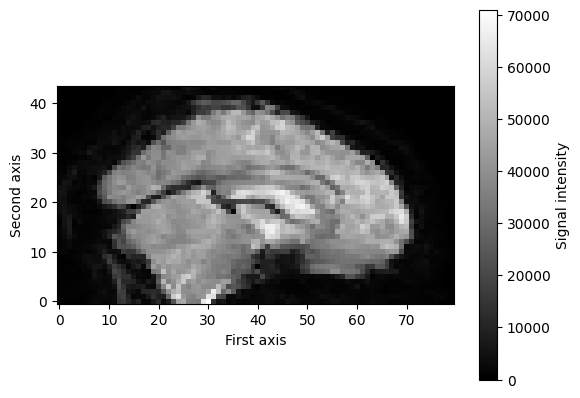

In [11]:
mid_slice_x_fmri = img_data[39, :, :, 0]  # x = 39, t = 0
print("Shape of slice: %s" % (mid_slice_x_fmri.shape,))

plt.imshow(mid_slice_x_fmri.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

we can also look at fMRI data from a different perspective, that is, from the time dimension! For example, we could extract a single voxel’s time series (i.e., how the signal intensity varies across time) and plot the signal intensity values of that voxel across time. First, let’s extract the time series of one particular voxel (e.g., the middle one across all spatial dimensions):

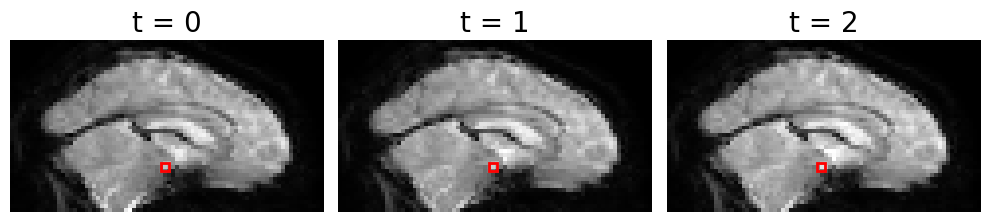

In [ ]:
from matplotlib import patches

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 20))  # 3 timepoints
# Loop over the first 3 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(img_data[39, :, :, t].T, cmap='gray', origin='lower')  # index with t!
    rect = patches.Rectangle((38, 10), 2, 2, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=20)
fig.tight_layout()

Voxel timeseries shape: (3,)


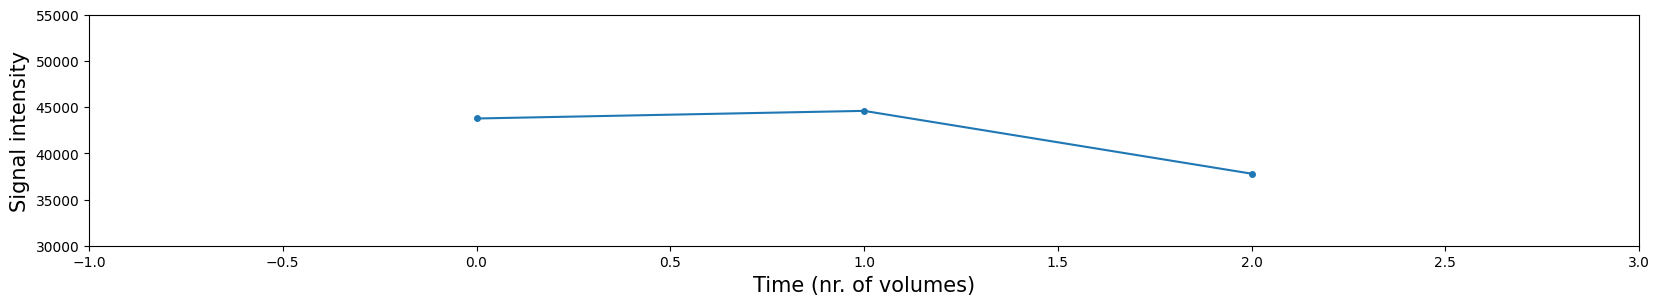

In [20]:
mid_vox_ts = img_data[39, 39, 21, :]  # note the ":", saying: give me ALL the timepoints
print("Voxel timeseries shape: %s" % (mid_vox_ts.shape,))
plt.figure(figsize=(20, 3))
plt.plot(mid_vox_ts, 'o-', ms=4)
plt.xlim(-1, mid_vox_ts.size)
plt.ylim(30000, 55000)
plt.ylabel('Signal intensity', fontsize=15)
plt.xlabel('Time (nr. of volumes)', fontsize=15)
plt.show()

# The affine

In fMRI, the affine matrix is a 4x4 matrix that describes how the 3D spatial coordinates of a voxel in an fMRI image relate to the 3D coordinates in scanner space (often Right-Anterior-Superior or RAS+). It essentially defines the transformation from voxel coordinates to real-world coordinates. This matrix combines various transformations like rotations, translations, and scaling to map the brain's image to its anatomical location. 

In [21]:
# import some stuff if you haven't done that already
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline

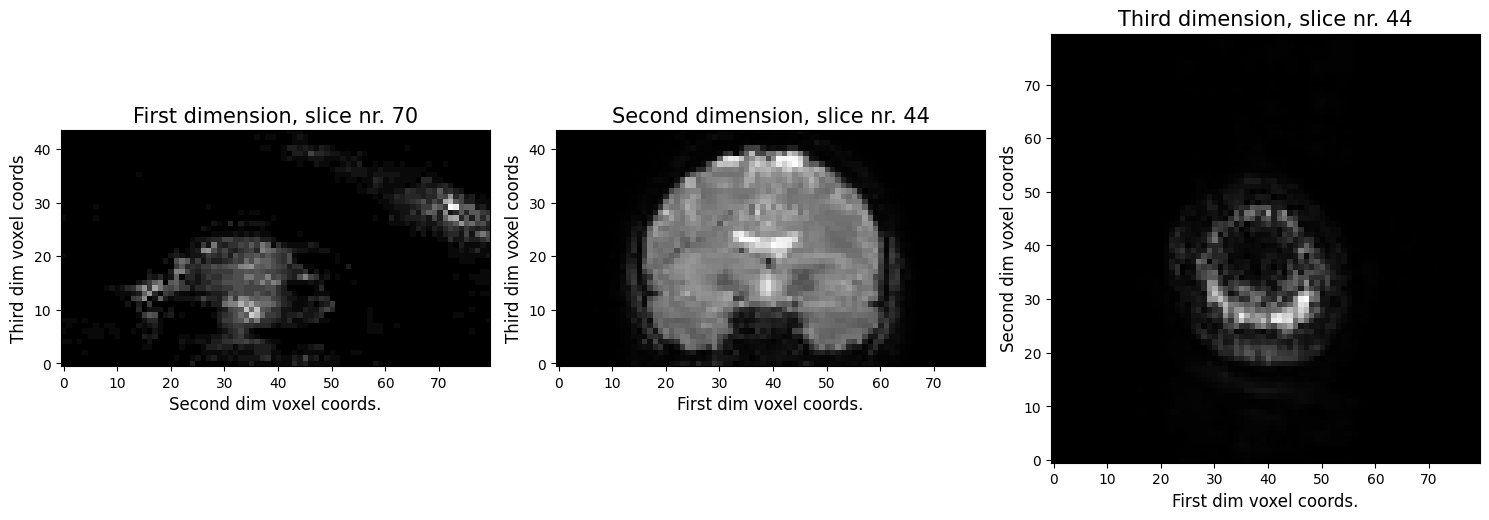

In [22]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
#(3, 44, 80)
ax[0].imshow(img_data[69, :, :,0].T, origin='lower', cmap='gray')
ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
ax[0].set_title('First dimension, slice nr. 70', fontsize=15)

ax[1].imshow(img_data[:, 43, :,0].T, origin='lower', cmap='gray')
ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
ax[1].set_title('Second dimension, slice nr. 44', fontsize=15)

ax[2].imshow(img_data[:, :,43,0].T, origin='lower', cmap='gray')
ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
ax[2].set_title('Third dimension, slice nr. 44', fontsize=15)

fig.tight_layout()

You can clearly see that the first voxel axis represents the sagittal dimension (left ←→ right), the second voxel axis represents the coronal dimension (anterior ←→ posterior), and the third voxel axis represents the axial dimension (inferior ←→ superior).

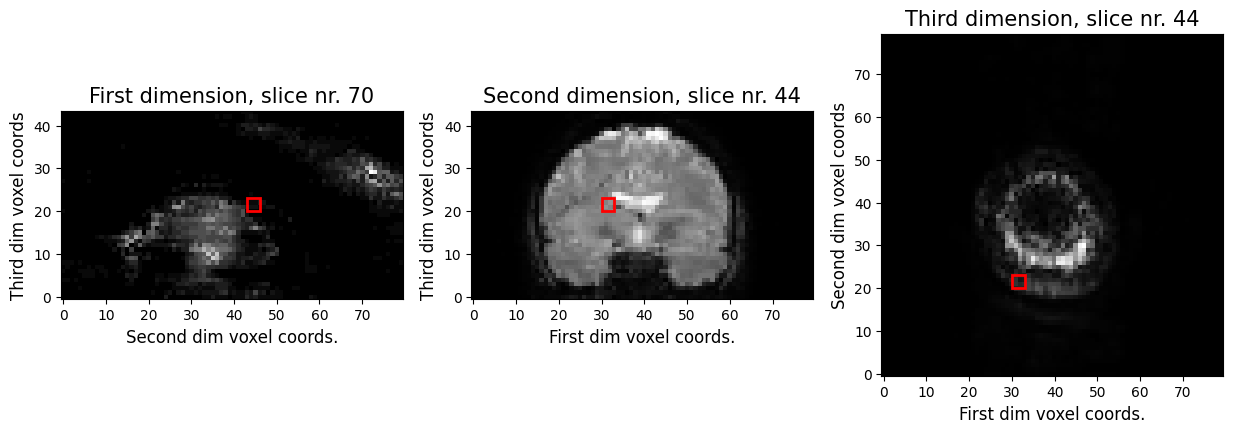

In [24]:
#  our voxel coordinate (30,20,43)
import matplotlib.patches as patches
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].imshow(img_data[69, :, :,0].T, origin='lower', cmap='gray')
ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
ax[0].set_title('First dimension, slice nr. 70', fontsize=15)
rect = patches.Rectangle((43, 20), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

ax[1].imshow(img_data[:, 43, :,0].T, origin='lower', cmap='gray')
ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
ax[1].set_title('Second dimension, slice nr. 44', fontsize=15)
rect = patches.Rectangle((30,20), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)

ax[2].imshow(img_data[:, :, 43,0].T, origin='lower', cmap='gray')
ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
ax[2].set_title('Third dimension, slice nr. 44', fontsize=15)
rect = patches.Rectangle(( 30,20), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[2].add_patch(rect)

#A = img.affinefig.tight_layout()

The corresponding to the actual coordinate for in fmri

In [25]:
A = img.affine
xyz1 = A @ np.array([30,20,43, 0])
print(xyz1)

[-77.58781207  -1.98195491 140.58111922   0.        ]


In [26]:
mri_file = '/kaggle/input/3t-fmri-dataset/ds003477/sub-03/ses-1/func/sub-03_ses-1_task-face_acq-Mb4Mm27Tr700_run-1_bold.nii'#'anat.nii.gz'
img = nib.load(mri_file)
print(img.shape)
img_data = img.get_fdata()
print(type(img_data))  # it's a numpy array!

(80, 80, 44, 342)
<class 'numpy.memmap'>


In [27]:
mid_vox_ts = img_data[39, 39, 21, :]  # note the ":", saying: give me ALL the timepoints
print("Voxel timeseries shape: %s" % (mid_vox_ts.shape,))


Voxel timeseries shape: (342,)


I have normalize the range of the matrix to be able to map the 

In [28]:
normalized_data = (mid_vox_ts - mid_vox_ts.min(axis=0)) / (mid_vox_ts.max(axis=0) - mid_vox_ts.min(axis=0))
mid_vox_ts=normalized_data*40


# GLM in fmri analysis
GLM (General Linear Model) is a statistical approach used in fMRI analysis to model the relationship between observed data (voxel time series) and experimental design (Stimulis).

Example of voxel signal


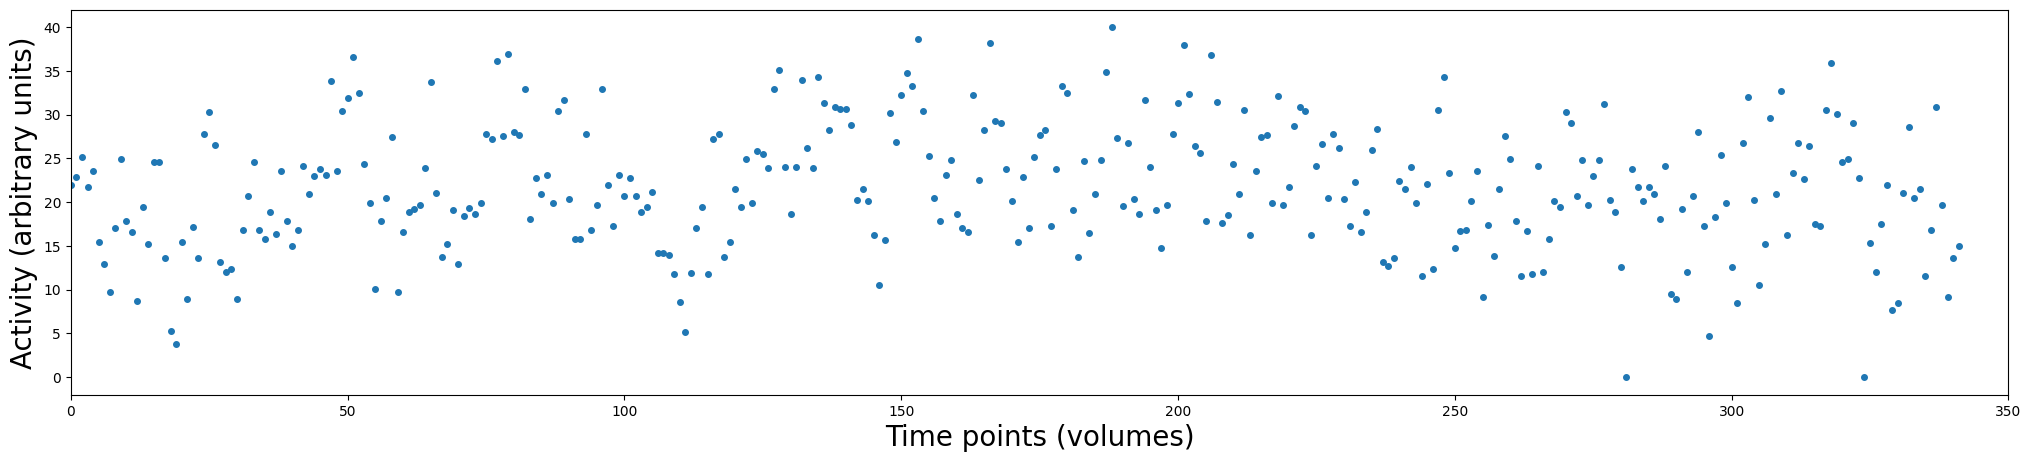

In [29]:
print('Example of voxel signal')
plt.figure(figsize=(25, 5))
plt.plot(mid_vox_ts, 'o', ms=4)
plt.xlim(0,350)
#plt.ylim(41000, 49000)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.show()

Example of voxel signal


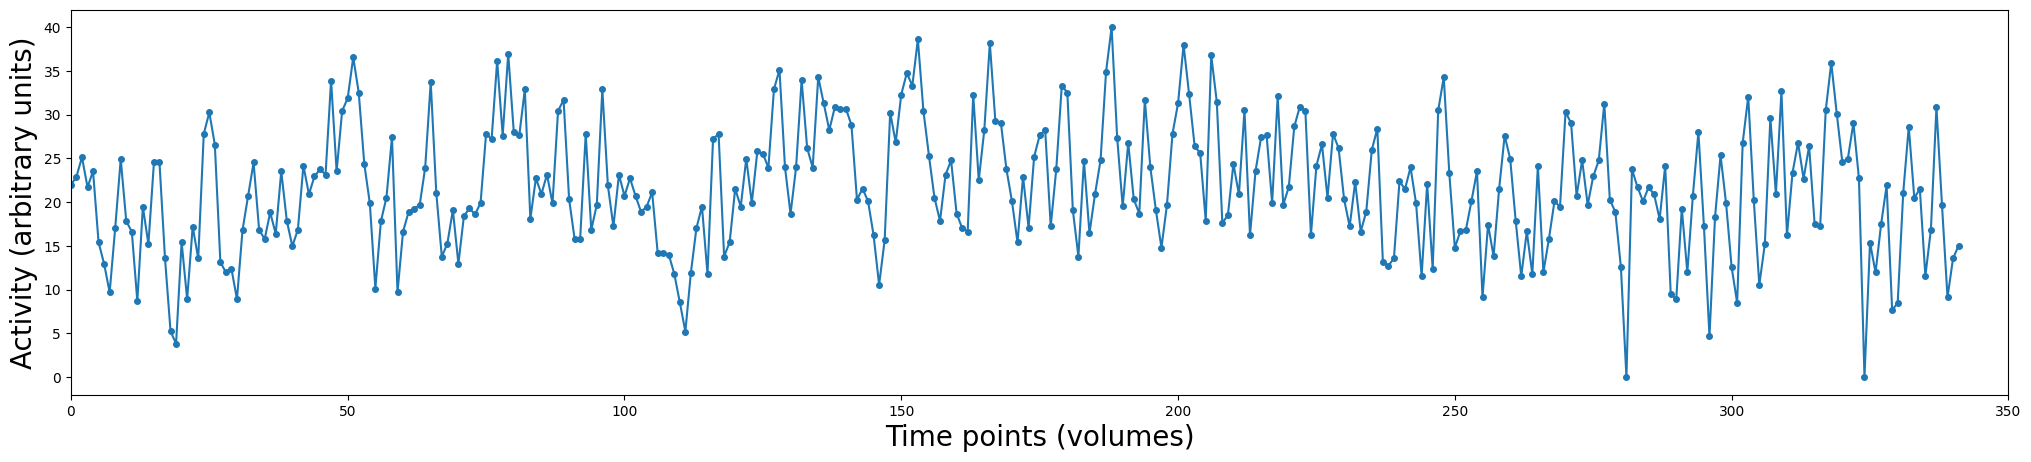

In [30]:
print('Example of voxel signal')
plt.figure(figsize=(25, 5))
plt.plot(mid_vox_ts, '-o', ms=4)
plt.xlim(0,350)
#plt.ylim(42500, 48000)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.show()

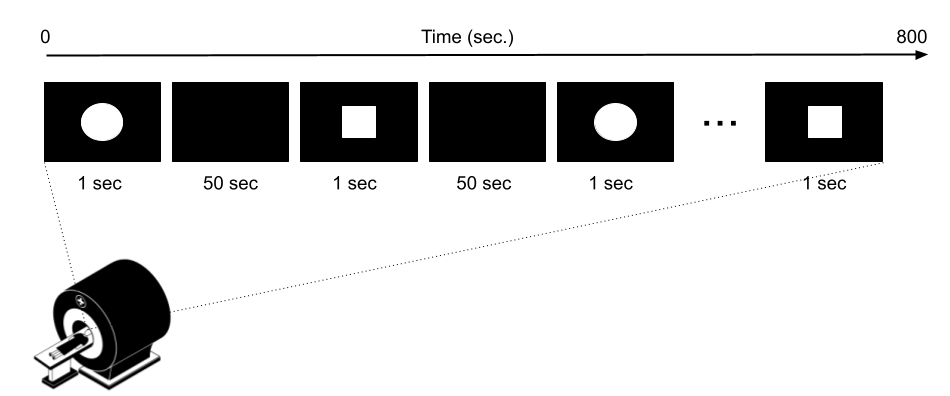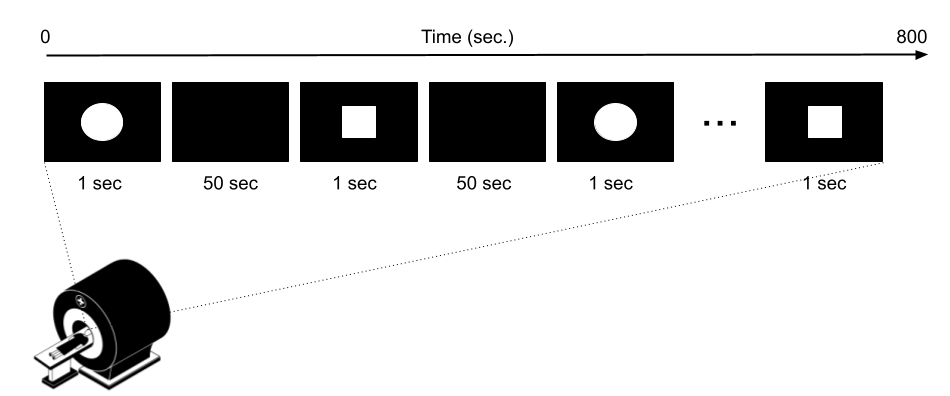


the stimulis is made of showing images of circle of squre images. For this tutorial we lump the onsets of these two types of stimuli together in one array. This predictor thus reflects the hypothesis that the signal is affected by the presence of a stimulus (regardless of whether this was a square or a circle).

In [137]:
#stimulus
onsets_squares = np.array([15, 115, 215, 315, 415, 515,], dtype=int)
onsets_circles = np.array([65, 165, 265, 365, 465, 565], dtype=int)
onsets_all = np.concatenate((onsets_squares, onsets_circles))
print(onsets_all)

[ 15 115 215 315 415 515  65 165 265 365 465 565]


In [138]:
predictor_all = np.zeros(600)  # because the experiment lasted 800 seconds
predictor_all[onsets_all] = 1  # set the predictor at the indices to 1

print("Shape of predictor: %s" % (predictor_all.shape,))
print("\nContents of our predictor array:\n%r" % predictor_all.T)

Shape of predictor: (600,)

Contents of our predictor array:
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 

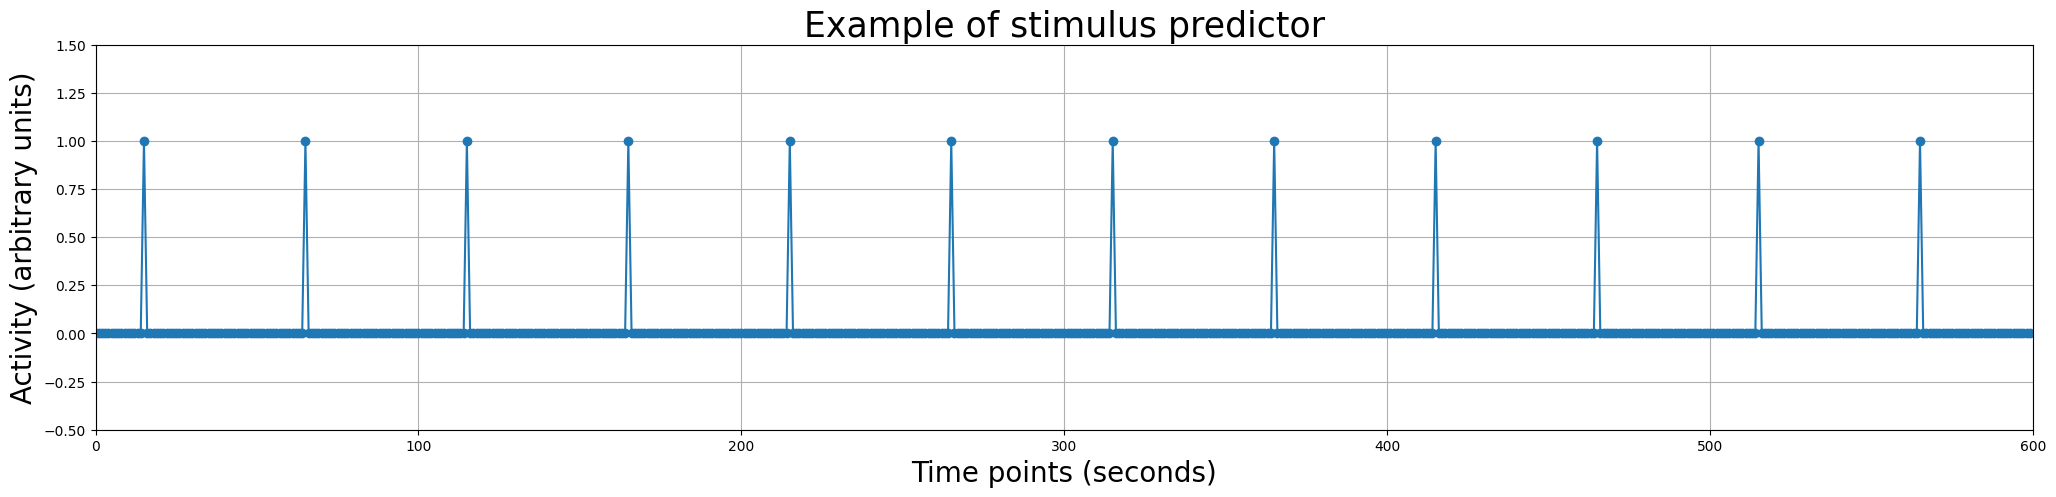

In [139]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 600)
plt.ylim(-.5, 1.5)
plt.title('Example of stimulus predictor', fontsize=25)
plt.grid()
plt.show()

# Resampling 
Resampling in Python can be done using the interp1d function from the scipy.interpolate package. It works by first creating a mapping between the scale of the original array and the values of the original array, and then converting the original array to a different scale. We’ll show you how this would be done with our predictor_all array.

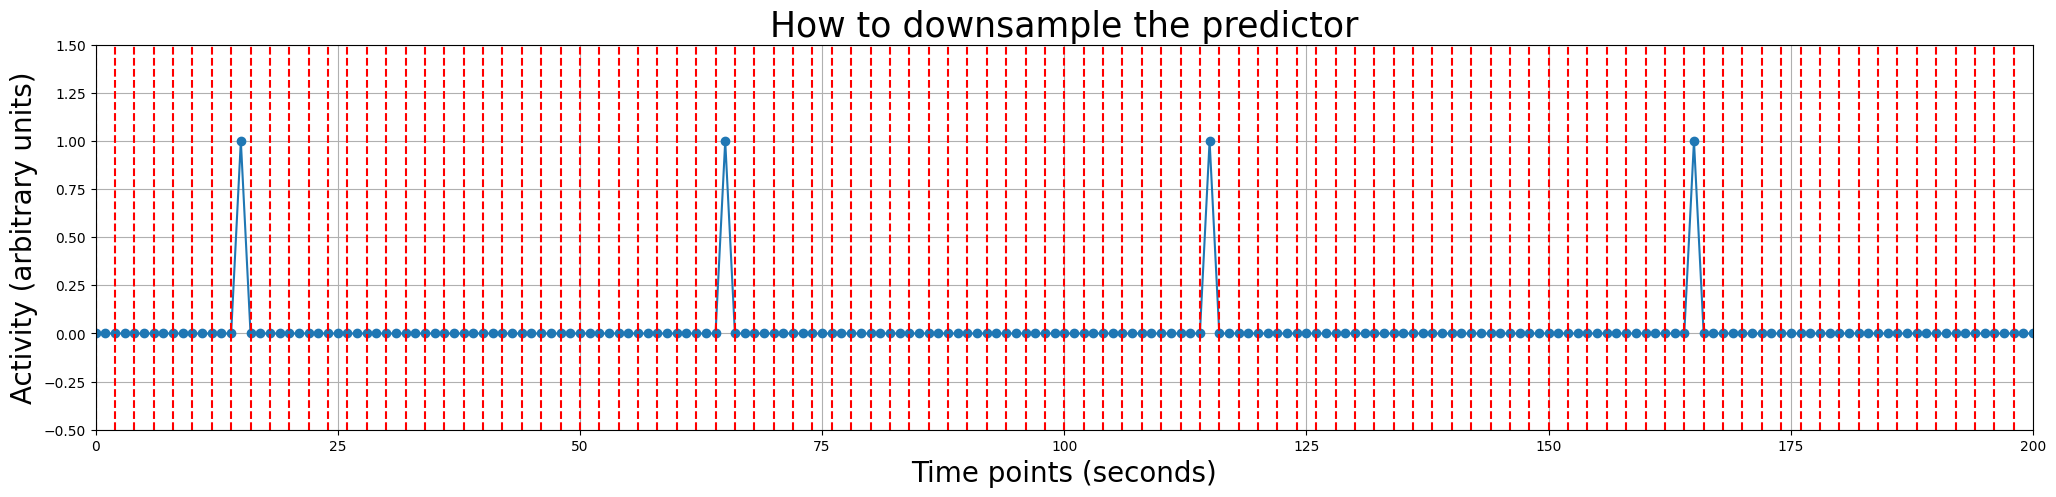

In [140]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 200)
plt.ylim(-.5, 1.5)
plt.title('How to downsample the predictor', fontsize=25)
plt.grid()

for t in np.arange(0, 200, 2):
    plt.axvline(t, ls='--', c='r')

plt.show()

In [141]:
from scipy.interpolate import interp1d
original_scale = np.arange(0, 600, 1)  # from 0 to 800 seconds
print("Original scale has %i datapoints (0-342, in seconds)" % original_scale.size)
resampler = interp1d(original_scale, predictor_all)

desired_scale = np.arange(0, 600, 2)
print("Desired scale has %i datapoints (0, 2, 4, ... 310, in volumes)" % desired_scale.size)
predictor_all_ds = resampler(desired_scale)

print("Downsampled predictor has %i datapoints (in volumes)" % predictor_all_ds.size)

Original scale has 600 datapoints (0-342, in seconds)
Desired scale has 300 datapoints (0, 2, 4, ... 310, in volumes)
Downsampled predictor has 300 datapoints (in volumes)


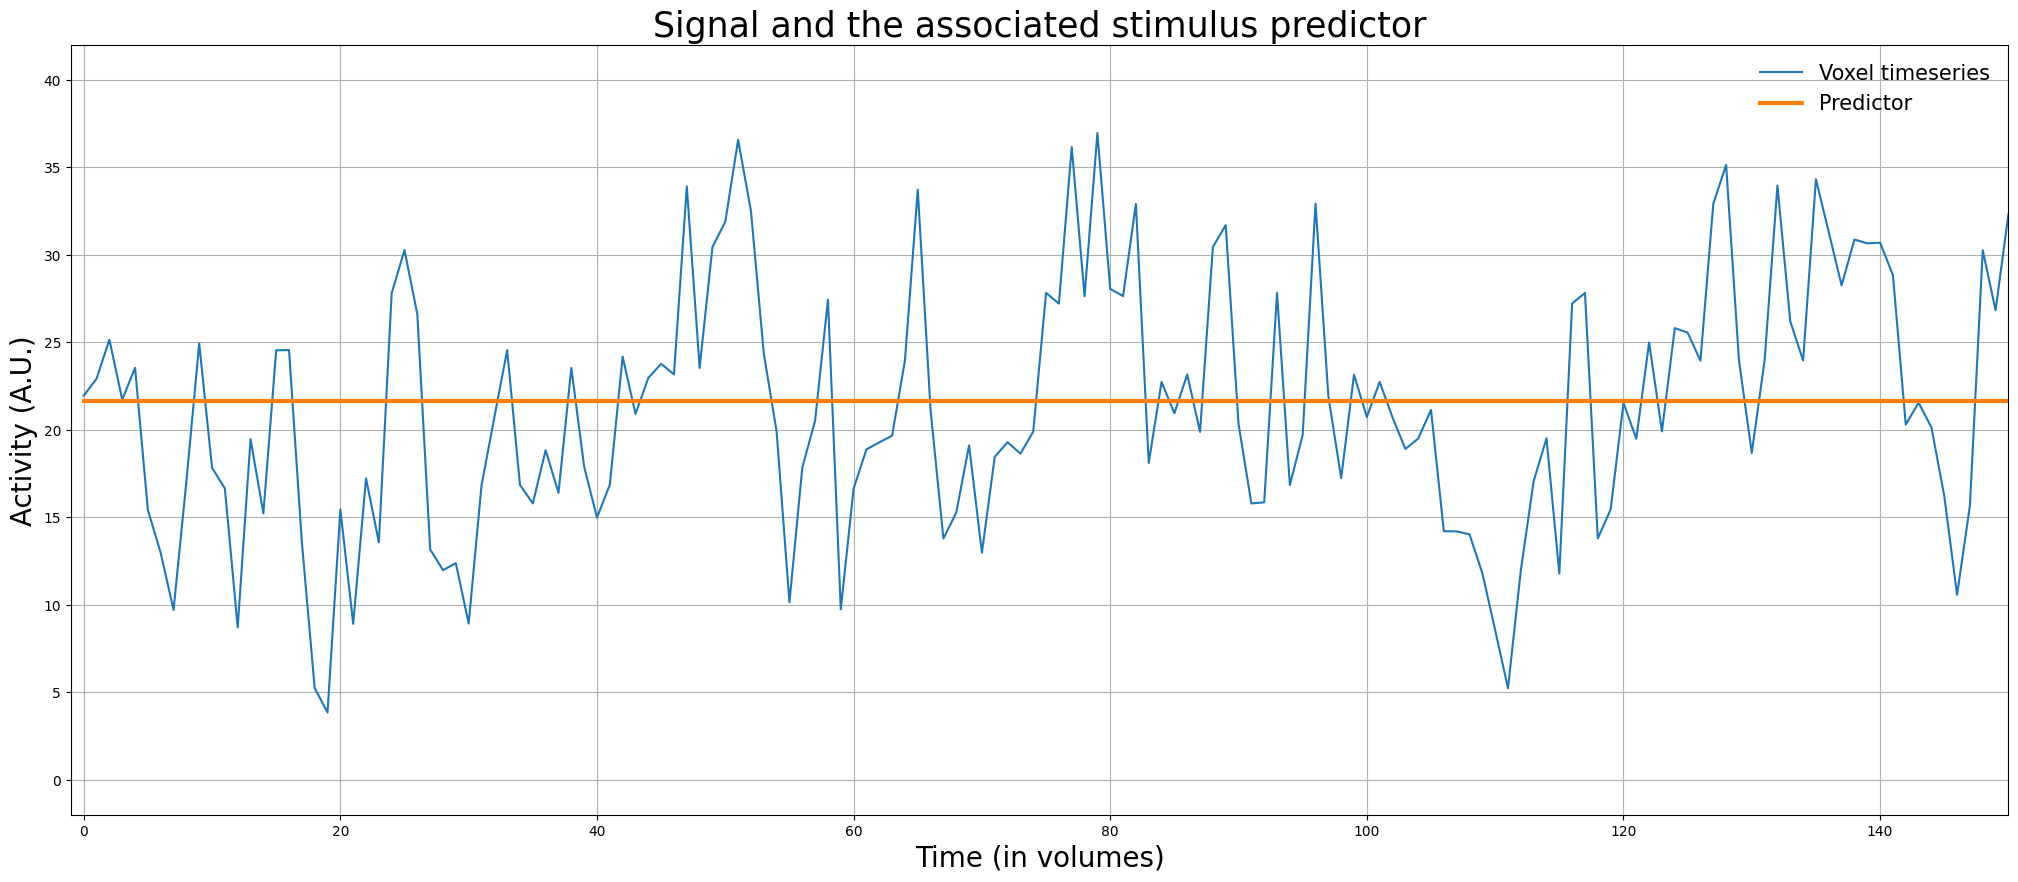

In [142]:
plt.figure(figsize=(25, 10))
plt.plot(mid_vox_ts)
plt.plot(predictor_all_ds + (mid_vox_ts).mean(), lw=3)
plt.xlim(-1, 150)
#plt.ylim(440,470)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.legend(['Voxel timeseries', 'Predictor'], fontsize=15, loc='upper right', frameon=False)
plt.title("Signal and the associated stimulus predictor", fontsize=25)
plt.grid()
plt.show()

In [143]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf
from scipy.interpolate import interp1d

# Using the BOLD response in GLM models
We assumed that in order to model activity in response to our stimuli, our predictor should capture an increase/decrease in activity at the moment of stimulus onset. But this is, given our knowledge of the BOLD-response, kind of unrealistic to assume: it is impossible to measure instantaneous changes in neural activity in response to stimuli or tasks with fMRI, because the BOLD-response is quite slow and usually peaks around 5-7 seconds after the ‘true’ neuronal activity (i.e. at cellular level).

In [144]:
TR = 2
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()
print("Size of canonical hrf variable: %i" % canonical_hrf.size)

Size of canonical hrf variable: 32


 In the above model, we have not incorporated either the lag (i.e. ~6 seconds) or the shape of the BOLD-response: we simply modelled activity as an instantaneous response to a stimulus event.

# convolution 

The figure of the HRF shows the expected idealized (noiseless) response to a single event. But how should we incorporate this HRF into our model? Traditionally, this is done using a mathematical operation called convolution. Basically, it “slides” the HRF across our 0-1 coded stimulus-vector from left to right and elementwise multiplies the HRF with the stimulus-vector.


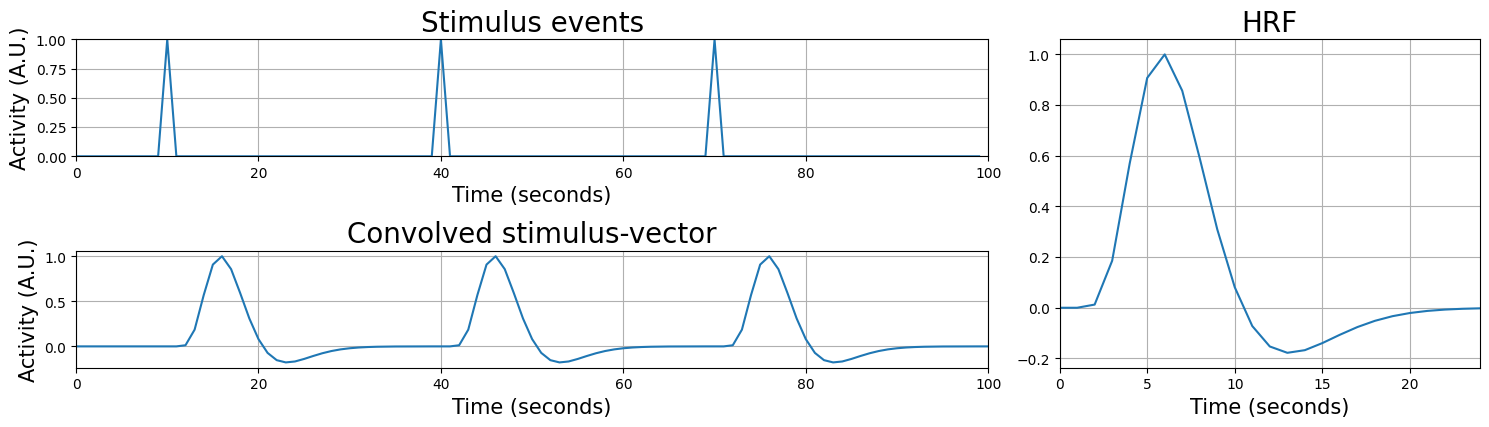

In [145]:
random_stimulus_onsets = [10, 40, 70]
random_stim_vector = np.zeros(100)
random_stim_vector[random_stimulus_onsets] = 1

plt.figure(figsize=(15, 6))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(random_stim_vector)
plt.xlim((0, 100))
plt.ylim((0, 1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('Stimulus events', fontsize=20)
plt.grid()

plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(canonical_hrf)
plt.title('HRF', fontsize=20)
plt.xlim(0, 24)
plt.xlabel("Time (seconds)", fontsize=15)
plt.grid()

convolved_stim_vector = np.convolve(random_stim_vector, canonical_hrf, 'full')
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(convolved_stim_vector)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.xlim(0, 100)
plt.tight_layout()
plt.grid()
plt.show()

In [146]:
'''We need to "squeeze" out the extra singleton axis, because that's
what the np.convolve function expects, i.e., arrays of shape (N,) and NOT (N, 1)
To go from (N, 1) --> (N,) we'll use the squeeze() method'''
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf)

print("The shape of the convolved predictor after convolution: %s" % (predictor_conv.shape,))

# After convolution, we also neem to "trim" off some excess values from
# the convolved signal (the reason for this is not important to understand)
predictor_conv = predictor_conv[:predictor_all.size]

print("After trimming, the shape is: %s" % (predictor_conv.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1),
# which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]

print("Shape after adding the new axis: %s" % (predictor_conv.shape,))

The shape of the convolved predictor after convolution: (631,)
After trimming, the shape is: (600,)
Shape after adding the new axis: (600, 1)


After adding convolution

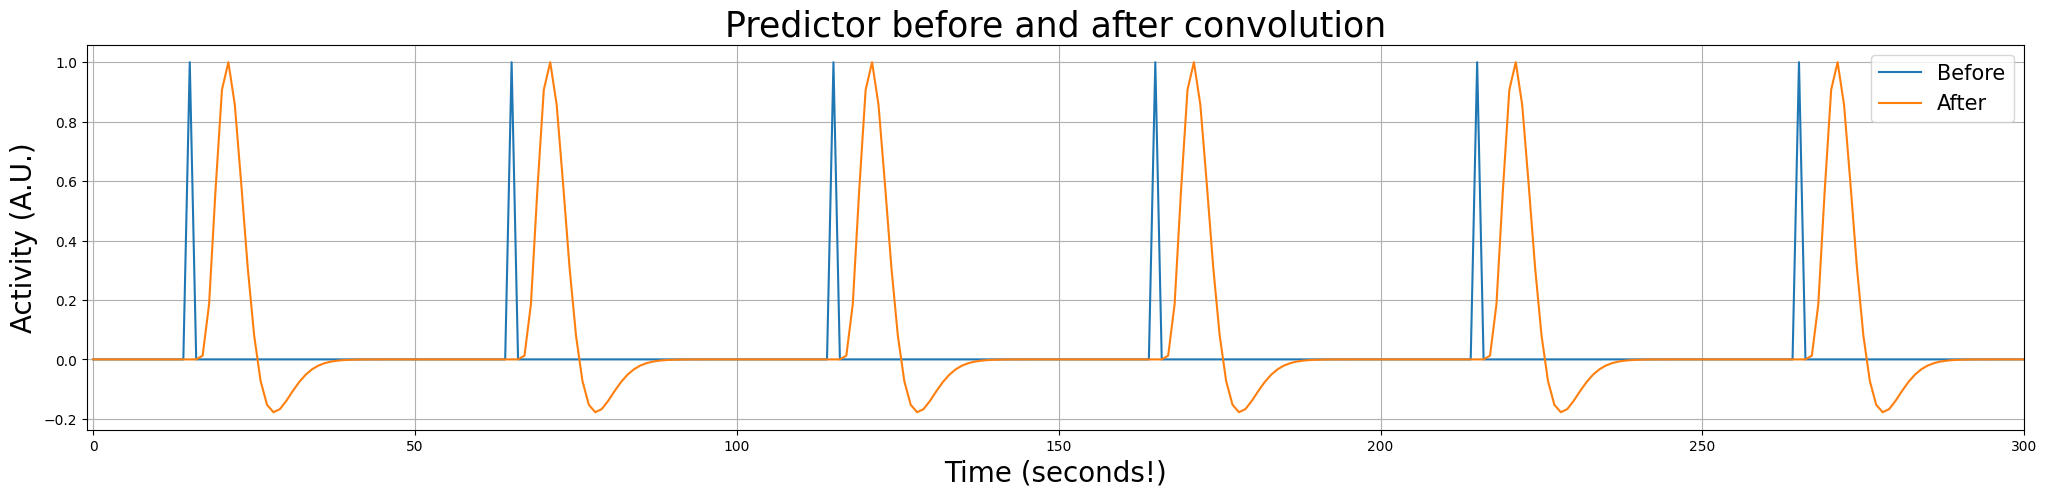

In [147]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all)
plt.plot(predictor_conv)
plt.xlim(-1, 300)
plt.title("Predictor before and after convolution", fontsize=25)
plt.xlabel("Time (seconds!)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.legend(['Before', 'After'], loc='upper right', fontsize=15)
plt.grid()
plt.show()

In [148]:
print("Size convolved predictor: %i" % predictor_conv.size)
print("Size voxel signal: %i" % mid_vox_ts.size)

Size convolved predictor: 600
Size voxel signal: 342


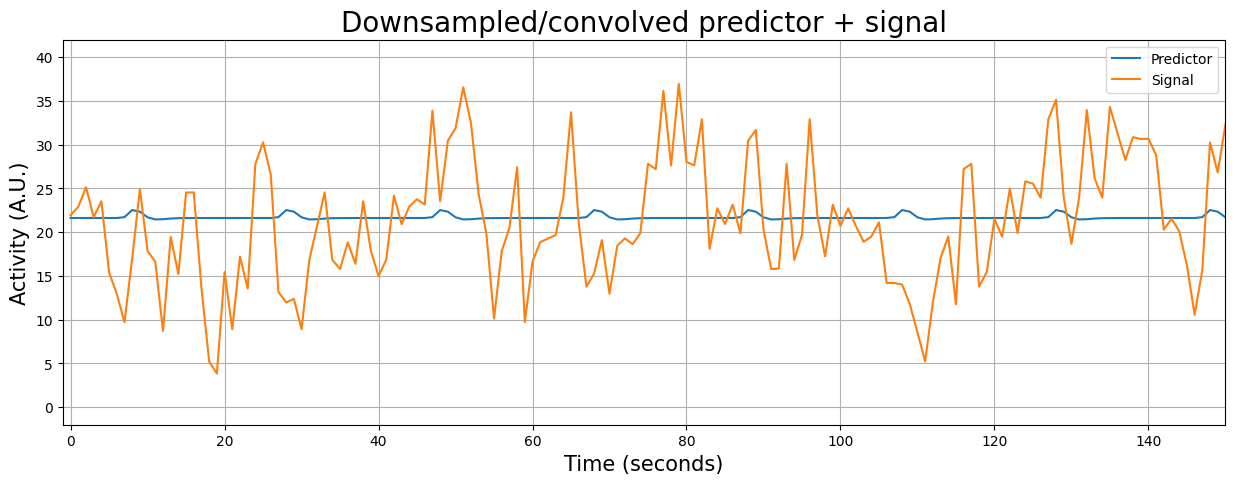

In [149]:
original_scale = np.arange(0, 600)
resampler = interp1d(original_scale, np.squeeze(predictor_conv))

desired_scale = np.arange(0, 600, 2.5)
predictor_conv_ds = resampler(desired_scale)

plt.figure(figsize=(15, 5))
plt.plot(predictor_conv_ds + mid_vox_ts.mean())
plt.plot(mid_vox_ts)
plt.grid()
plt.title('Downsampled/convolved predictor + signal', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend(['Predictor', 'Signal'])
plt.xlim(-1, 150)
plt.show()

In [150]:
intercept.shape

(240, 0)

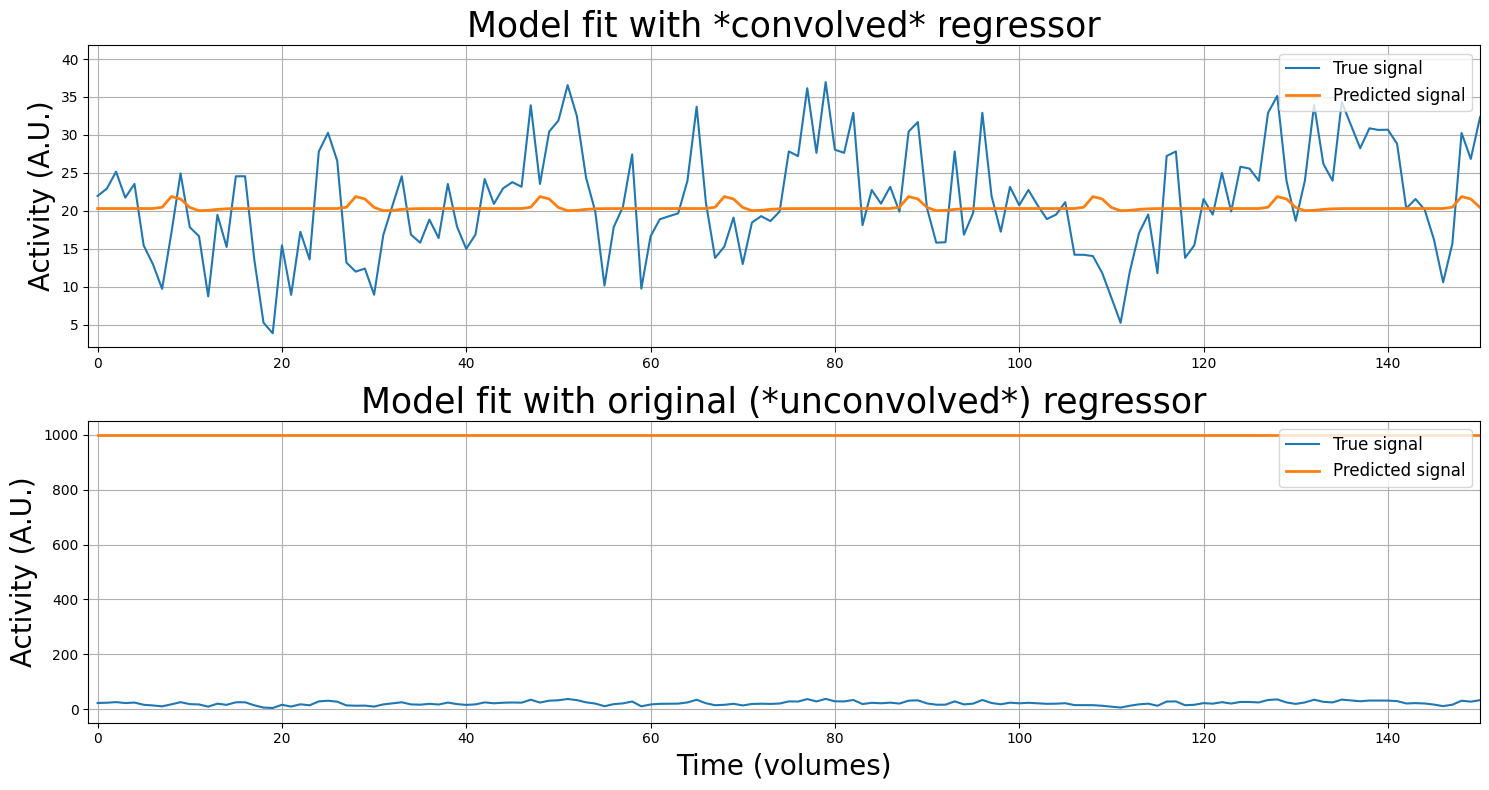

In [177]:
if predictor_conv_ds.ndim == 1:
    # Add back a singleton axis (which was removed before downsampling)
    # otherwise stacking will give an error
    predictor_conv_ds = predictor_conv_ds[:, np.newaxis]

intercept = np.ones((predictor_conv_ds.size, 1))
X_conv = np.hstack((intercept, predictor_conv_ds))
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ (mid_vox_ts[:240])

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(mid_vox_ts[:240])
plt.plot(X_conv @ betas_conv-2, lw=2)
plt.xlim(-1, 150)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'],
           fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(mid_vox_ts[:300])
betas_simple = np.array([1000.64701684, 1.02307437])
icept = np.ones((predictor_all_ds[:, np.newaxis].size, 1))
X_simple = np.hstack((icept, predictor_all_ds[:, np.newaxis]))
plt.plot(X_simple @ betas_simple, lw=2)
plt.xlim(-1, 150)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with original (*unconvolved*) regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel("Time (volumes)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

Finally … we’re ready to see whether the HRF-based predictor actually models our original voxel signal (voxel_signal, from earlier in the tutorial) more accurately! Let’s create a proper design-matrix (
) by stacking an intercept with the stimulus-regressor, perform the regression analysis, and check out the results (by plotting the predicted signal against the true signal). For comparison, we’ll also plot the original (unconvolved) model as well!


In [182]:
from numpy.linalg import lstsq  # numpy implementation of OLS, because we're lazy

y_hat_conv = X_conv @ betas_conv
y_hat_orig = X_simple @ lstsq(X_simple, mid_vox_ts[:300], rcond=None)[0]

MSE_conv = ((y_hat_conv - mid_vox_ts[:240]) ** 2).mean()
MSE_orig = ((y_hat_orig - mid_vox_ts[:300]) ** 2).mean()

print("MSE of model with convolution is %.3f while the MSE of the model without convolution is %.3f." %
     (MSE_conv, MSE_orig))

R2_conv = 1 - (np.sum((mid_vox_ts[:240] - y_hat_conv) ** 2) / np.sum((mid_vox_ts[:240] - mid_vox_ts[:240].mean()) ** 2))
R2_orig = 1 - (np.sum((mid_vox_ts[:300] - y_hat_orig) ** 2) / np.sum((mid_vox_ts[:300] - mid_vox_ts[:300].mean()) ** 2))

print("R-squared of model with convolution is %.5f and without convolution it is %.5f." % 
     (R2_conv, R2_orig))

MSE of model with convolution is 49.714 while the MSE of the model without convolution is 49.779.
R-squared of model with convolution is 0.00398 and without convolution it is 0.00000.
